# Brief description of the problem and data (5 pts) 

 #### Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

There are 220k test images that are 32x32 pixels.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

###### Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

In [12]:
#!pip install keras
#!pip install tensorflow --user
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn --user
#!pip install tensorflow-rocm --user
#!pip install keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/2b/39/21f819fcda657c37519cf817ca1cd03a8a025262aad360876d2a971d38b3/keras_tuner-1.4.6-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/128.9 kB ? eta -:--:--
   ---------------------------- ----------- 92.2/128.9 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 128.9/128.9 kB 2.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#Let's import first
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [2]:
labels_df = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')
train_images_dir = './histopathologic-cancer-detection/train/'

def load_images(image_paths, image_size=(32, 32)):
    images = []
    for path in image_paths:
        img = Image.open(path).resize(image_size)
        img_array = np.array(img) / 255.0 
        images.append(img_array)
    return np.array(images)

image_paths = [train_images_dir + f'/{img_id}.tif' for img_id in labels_df['id']]

train_images = load_images(image_paths)

In [51]:
train_labels = np.array(labels_df['label'])

[0 1 0 ... 0 0 1]


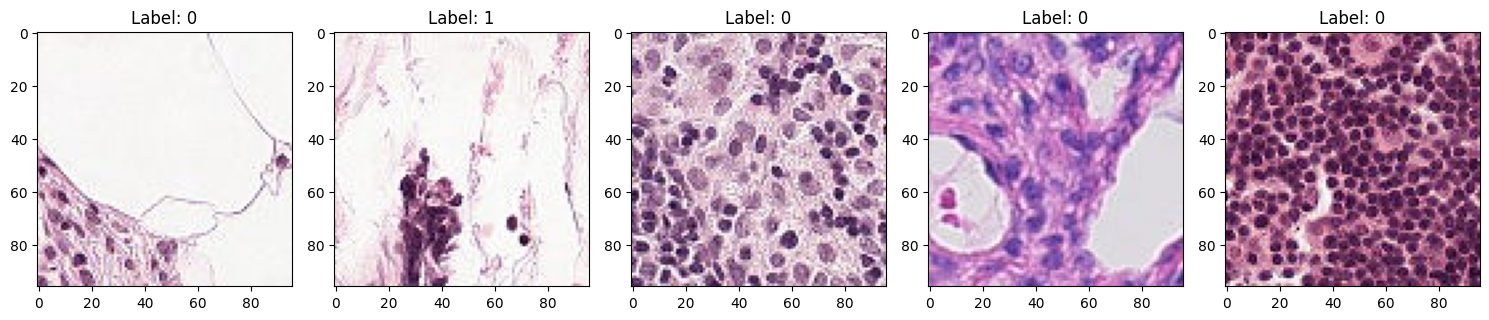

In [5]:
first_5 = labels_df.head(5)

plt.figure(figsize=(15, 3))  
for i, row in enumerate(first_5.iterrows()):
    image_id, label = row[1]
    image_path = train_images_dir + f'{image_id}.tif'
    image = Image.open(image_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f'Label: {label}')

plt.tight_layout()
plt.show()

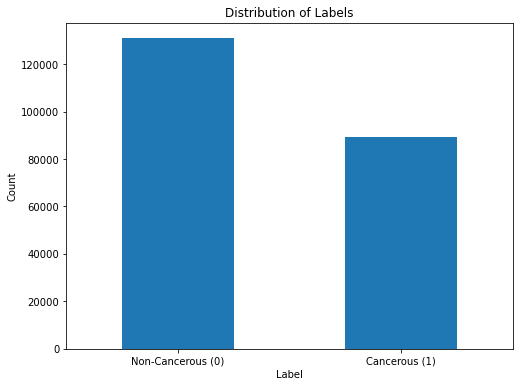

In [14]:
label_count = labels_df['label'].value_counts()

plt.figure(figsize=(8, 6))
label_count.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Cancerous (0)', 'Cancerous (1)'], rotation=0)
plt.show()

In [13]:
image_ids = [os.path.splitext(file)[0] for file in os.listdir(train_images_dir) if file.endswith('.tif')]

missing_labels = [img_id for img_id in image_ids if img_id not in labels_df['id'].values]

print(f'Number of images without labels: {len(missing_labels)}')

KeyboardInterrupt: 

In [ ]:
problem_images = []

for img_id in labels_df['id']:
    image_path = os.path.join(train_images_dir, img_id + '.tif')
    try:
        img = Image.open(image_path)
        img.verify()
    except (IOError, SyntaxError) as e:
        problem_images.append(img_id)

print(f'Number of missing/corrupted images: {len(problem_images)}')

I believe the dataset provided is clean and free of issues and therefore i will move on to 

# Model Architecture (25 pts)

#### Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

As shown in class, it's good to have "loops" of layers. Let's first compare a single conv layer loop to a double conv layer loop

In [4]:
# Let's create a general function to create CNN models
def create_model(num_loops, num_layers, scale_factor=2, num_filters=32, dropout=0.5, batch_norm=False, learning_rate=0.001):
    """
    Parameters:
    num_loops (int): Number of loops for adding convolutional layers. Must be positive.
    num_layers (int): Number of layers in each loop. Must be positive.
    scale_factor (int): Factor to scale the number of neurons.
    num_filters (int): Number of filters for the first convolutional layer.
    dropout (float): Dropout rate.
    """
    if num_loops < 1 or num_layers < 1:
        raise ValueError("num_loops and num_layers must be positive integers.")

    model = Sequential()
    for i in range(num_loops):
        num_neuron = num_filters * (scale_factor ** i)
        for j in range(num_layers):
            if i == 0 and j == 0:
                model.add(Conv2D(num_neuron, (3, 3), padding='same', input_shape=(32,32,3)))
            else:
                model.add(Conv2D(num_neuron, (3, 3), padding='same'))
                
            if batch_norm:
                model.add(BatchNormalization())
                
            model.add(Activation('relu'))

        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(32 * num_layers))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
current_model = create_model(3, 2)

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Now it's time to train the models and compare

## Working Notes

3 Loop Models no regularization:
- Single Layer
- Double Layer -> best acc: 0.8920179009437561
- Triple Layer w Batch Norm -> Overfit

3 Loop Models w regularization:
- Triple layer w Batch Norm -> Overfit
- Double Layer w Batch Norm -> No significant improvement after epoch 1
- Double Layer no batch norm -> shit

All my efforts at improving the model (batch norm, adam optimizer, l2 regularization) is not working. It's making the model much worse.

#### Let's go from 10 to 25 epochs

3 loop models no regularization:
- Double Layer -> Early stop @ 10 epochs (5 patience)
- Double Layer -> best acc: 0.905 (10 patience)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.15, random_state=0)

In [46]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0008,
    patience=25,
    restore_best_weights=True,
    mode='min'
)

In [8]:
current_model_history = current_model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val, Y_val),
    shuffle=True,
    callbacks=[early_stopping]
)

current_model_val_loss, current_model_val_accuracy = current_model.evaluate(X_val, Y_val)
print(f'Validation Loss: {current_model_val_loss}')
print(f'Validation Accuracy: {current_model_val_accuracy}')

Epoch 1/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 110s 18ms/step - accuracy: 0.7482 - loss: 0.5157 - val_accuracy: 0.7942 - val_loss: 0.4185
Epoch 2/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 108s 18ms/step - accuracy: 0.8408 - loss: 0.3715 - val_accuracy: 0.8461 - val_loss: 0.3585
Epoch 3/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 102s 17ms/step - accuracy: 0.8558 - loss: 0.3383 - val_accuracy: 0.8499 - val_loss: 0.3522
Epoch 4/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 104s 18ms/step - accuracy: 0.8673 - loss: 0.3179 - val_accuracy: 0.8504 - val_loss: 0.3415
Epoch 5/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 104s 18ms/step - accuracy: 0.8745 - loss: 0.3020 - val_accuracy: 0.8878 - val_loss: 0.2749
Epoch 6/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 104s 18ms/step - accuracy: 0.8829 - loss: 0.2839 - val_accuracy: 0.8898 - val_loss: 0.2651
Epoch 7/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 107s 18ms/step - accuracy: 0.8891 - loss: 0.2734 - val_accuracy: 0.8801 - val_loss: 0.2845
Epoch 8/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 104s 18ms/step - accuracy: 

# Results and Analysis (35 pts) 

#### Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

#### Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [ ]:
#Insert first training screenshots here

In [36]:
#Hyperparameter Tuning
def tuning_model(hp):
    model = tf.keras.Sequential()
    for i in range(hp.Int('num_conv_layers', 2, 3)):
        model.add(tf.keras.layers.Conv2D(filters=hp.Int(f'num_filters_{i}', min_value=32, max_value=96, step=32),
                                         kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5, 7]),
                                         padding='same',
                                         activation='relu',
                                         input_shape=(32, 32, 3) if i == 0 else None))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=64, max_value=128, step=64), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [29]:
#This is using Hyperband
import kerastuner as kt

hyper_tuner = kt.Hyperband(tuning_model,
                     objective='val_accuracy',
                     max_epochs=25,
                     directory='./histopathologic-cancer-detection/tuning_results',
                     project_name='cnn_tuner')

hyper_tuner.search(X_train, Y_train, epochs=25, validation_split=0.2)

Reloading Tuner from ./histopathologic-cancer-detection/tuning_results\cnn_tuner\tuner0.json


In [12]:
hyper_best_hps = hyper_tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
hyper_model = tuning_model(hyper_best_hps)
hyper_model_history = hyper_model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val, Y_val),
    shuffle=True,
    callbacks=[early_stopping]
)

hyper_model_val_loss, hyper_model_val_accuracy = hyper_model.evaluate(X_val, Y_val)
print(f'Validation Loss: {hyper_model_val_loss}')
print(f'Validation Accuracy: {hyper_model_val_accuracy}')

Epoch 1/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - accuracy: 0.4040 - loss: 9.5022 - val_accuracy: 0.4061 - val_loss: 9.4677
Epoch 2/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.4041 - loss: 9.4997 - val_accuracy: 0.4061 - val_loss: 9.4677
Epoch 3/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.4072 - loss: 9.4504 - val_accuracy: 0.4061 - val_loss: 9.4677
Epoch 4/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.4047 - loss: 9.4903 - val_accuracy: 0.4061 - val_loss: 9.4677
Epoch 5/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.4039 - loss: 9.5035 - val_accuracy: 0.4061 - val_loss: 9.4677
Epoch 6/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.4055 - loss: 9.4773 - val_accuracy: 0.4061 - val_loss: 9.4677
Epoch 7/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.4044 - loss: 9.4955 - val_accuracy: 0.4061 - val_loss: 9.4677
Epoch 8/25
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.4053 - loss: 

In [ ]:
grid_tuner = kt.GridSearch(
    hypermodel=tuning_model,
    objective='val_accuracy',
    max_trials=50,
    directory='./histopathologic-cancer-detection/tuning_results',
    project_name='gridsearch_cnn'
)

grid_tuner.search(X_train, Y_train, epochs=15, validation_split=0.2)

Trial 48 Complete [00h 17m 16s]
val_accuracy: 0.8508626222610474

Best val_accuracy So Far: 0.8846521973609924
Total elapsed time: 09h 35m 09s

Search: Running Trial #49

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_conv_layers
32                |32                |num_filters_0
7                 |3                 |kernel_size_0
96                |96                |num_filters_1
3                 |5                 |kernel_size_1
64                |128               |units

Epoch 1/15
4676/4676 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.7072 - loss: 0.5740 - val_accuracy: 0.7876 - val_loss: 0.4669
Epoch 2/15
4676/4676 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.8178 - loss: 0.4112 - val_accuracy: 0.8149 - val_loss: 0.4121
Epoch 6/15
4676/4676 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.8245 - loss: 0.3973 - val_accuracy: 0.8336 - val_loss: 0.3765
Epoch 7/15
4676/4676 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.841

## Grid Search Notes

- Smaller learning rate looks better but needs more epochs (fine)
- Small dropout changes dont effect much -> large increases appear to be helpful
- Units in Dense Layer would benefit from being above 64 -> lets use 128
- The following layers should have more neurons than the previous one

In [43]:
grid_best_hps = grid_tuner.get_best_hyperparameters(num_trials=49)[0]
for hparam in grid_best_hps.space:
    print(f'{hparam.name}: {grid_best_hps.get(hparam.name)}')

num_conv_layers: 2
num_filters_0: 32
kernel_size_0: 3
num_filters_1: 96
kernel_size_1: 5
units: 128


In [47]:
grid_model = tuning_model(grid_best_hps)
grid_model_history = grid_model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=150,
    validation_data=(X_val, Y_val),
    shuffle=True,
    callbacks=[early_stopping]
)

grid_model_val_loss, grid_model_val_accuracy = grid_model.evaluate(X_val, Y_val)
print(f'Validation Loss: {grid_model_val_loss}')
print(f'Validation Accuracy: {grid_model_val_accuracy}')

Epoch 1/150
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - accuracy: 0.7673 - loss: 0.4938 - val_accuracy: 0.8287 - val_loss: 0.3903
Epoch 2/150
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - accuracy: 0.8250 - loss: 0.3958 - val_accuracy: 0.8434 - val_loss: 0.3505
Epoch 3/150
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - accuracy: 0.8409 - loss: 0.3636 - val_accuracy: 0.8509 - val_loss: 0.3450
Epoch 4/150
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - accuracy: 0.8525 - loss: 0.3421 - val_accuracy: 0.8509 - val_loss: 0.3447
Epoch 5/150
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - accuracy: 0.8585 - loss: 0.3277 - val_accuracy: 0.8663 - val_loss: 0.3141
Epoch 6/150
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - accuracy: 0.8672 - loss: 0.3115 - val_accuracy: 0.8660 - val_loss: 0.3128
Epoch 7/150
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - accuracy: 0.8734 - loss: 0.3007 - val_accuracy: 0.8687 - val_loss: 0.3068
Epoch 8/150
5845/5845 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - accuracy: 

# Conclusion (15 pts)

#### Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

I took the approach of building a simple CNN model that performs well and then making it better. I found that 3 loops would make the model too complex
and i decided there that there should be 2 loops. Then i ran a grid search to narrow down certain hyperparameters like learning rate and dropout rate.
Once those were solidified i ran through the rest of the hyperparameters.

In the future, i want to be able to run a wider grid search, however, i havent configured my (AMD) GPU and i dont have the time to train for 12+ hours.
The longest grid search i ran was 10 hrs.

Overall, i learned so much! Complexity is important, attention to detail (my models werent improving because i used the wrong activation in the last dense neuron). Takeaways are i can start with hyperparameter tuning if i dont know where to start and have the time. I think i liked my process of narrowing down options quickly and then running a search to find the gritty details.

In [52]:
#Now format csv to submit
test_images_dir = './histopathologic-cancer-detection/test/'

test_image_files = os.listdir(test_images_dir)
test_image_ids = [os.path.splitext(file)[0] for file in test_image_files]
test_image_paths = [os.path.join(test_images_dir, file) for file in test_image_files]

test_images = load_images(test_image_paths)

In [53]:
#Now we predict the test_images
y_pred = grid_model.predict(test_images)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


array([9.8475212e-01, 9.9555272e-01, 9.6126473e-01, ..., 3.5819390e-14,
       9.0417004e-01, 8.3468771e-03], dtype=float32)

In [65]:
test_predictions = pd.DataFrame({
    'id': test_image_ids,
    'label': np.around(y_pred.flatten())
})

test_predictions.to_csv('./histopathologic-cancer-detection/submission_final.csv', index=False)